In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)

In [2]:
data = pd.read_csv("https://drive.google.com/uc?id=1wD8h8pjCLDy1RbuPDZBSa3zH45TZL7ha&export=download") 

In [3]:
data

,Unnamed: 0,state,year,cigsale,lnincome,beer,age15to24,retprice
0,1,1,1970,89.800003,NaN,NaN,0.178862,39.599998
1,2,1,1971,95.400002,NaN,NaN,0.179928,42.700001
2,3,1,1972,101.099998,9.498476,NaN,0.180994,42.299999
3,4,1,1973,102.900002,9.550107,NaN,0.182060,42.099998
4,5,1,1974,108.199997,9.537163,NaN,0.183126,43.099998
...,...,...,...,...,...,...,...,...
1204,1205,39,1996,110.300003,10.016768,24.6,NaN,162.500000
1205,1206,39,1997,108.800003,10.025613,24.6,NaN,164.100006
1206,1207,39,1998,102.900002,NaN,NaN,NaN,168.800003
1207,1208,39,1999,104.800003,NaN,NaN,NaN,189.600006


In [4]:
data = data.drop(columns=['Unnamed: 0'])

In [6]:
from scipy.spatial import distance

# Define pre-treatment period
pre_treatment = data['year'] < 1989

# Define treated and control groups
treated = data['state'] == 3
control = data['state'] != 3

# Select covariates for balance check (excluding identifiers and outcome)
covariates = ['lnincome', 'beer', 'age15to24', 'retprice']

# Compute means for treated and control in pre-treatment period
treated_means = data.loc[pre_treatment & treated, covariates].mean()
control_means = data.loc[pre_treatment & control, covariates].mean()

# Compute pooled covariance matrix for pre-treatment period
pooled_cov = data.loc[pre_treatment, covariates].cov()

# Compute Mahalanobis distance
mahal_dist = distance.mahalanobis(treated_means, control_means, np.linalg.inv(pooled_cov))
# Compute Mahalanobis distance between treated (state 3) and each other state in pre-treatment period
state_ids = data.loc[pre_treatment & control, 'state'].unique()
mahal_dist_by_state = {}

for s in state_ids:
    state_means = data.loc[pre_treatment & (data['state'] == s), covariates].mean()
    dist = distance.mahalanobis(treated_means, state_means, np.linalg.inv(pooled_cov))
    mahal_dist_by_state[s] = dist

print("Mahalanobis distance (pre-1989, state 3 vs each state):")
for s, dist in mahal_dist_by_state.items():
    print(f"State {s}: {dist:.4f}")

Mahalanobis distance (pre-1989, state 3 vs each state):
State 1: 2.9604
State 2: 3.4718
State 4: 0.9533
State 5: 1.5490
State 6: 1.0534
State 7: 2.0437
State 8: 3.3367
State 9: 0.7305
State 10: 1.5467
State 11: 1.6872
State 12: 1.2664
State 13: 2.6051
State 14: 2.8375
State 15: 2.6348
State 16: 1.1200
State 17: 3.9642
State 18: 1.9098
State 19: 2.8854
State 20: 1.7989
State 21: 3.4385
State 22: 3.3089
State 23: 3.4972
State 24: 2.2625
State 25: 2.1090
State 26: 1.4693
State 27: 2.1692
State 28: 1.7942
State 29: 1.5481
State 30: 3.1958
State 31: 2.4276
State 32: 2.5907
State 33: 2.4430
State 34: 3.2286
State 35: 2.6188
State 36: 1.0076
State 37: 3.2220
State 38: 3.0078
State 39: 1.0671


In [7]:
# Create a DataFrame with state, Mahalanobis distance, and ranking
mahal_df = pd.DataFrame({
    'state': list(mahal_dist_by_state.keys()),
    'Mahalanobis distance': list(mahal_dist_by_state.values())
})

# Rank states by closeness (lower distance = closer, rank 1 is closest)
mahal_df['Rank'] = mahal_df['Mahalanobis distance'].rank(method='min').astype(int)

# Optional: sort by distance
mahal_df = mahal_df.sort_values('Mahalanobis distance')

# If you have a mapping from state number to state name, you can add it here.
# For now, just use the state number as "state name"
mahal_df = mahal_df.rename(columns={'state': 'state name'})

mahal_df.reset_index(drop=True, inplace=True)
mahal_df

,state name,Mahalanobis distance,Rank
0,9,0.730495,1
1,4,0.953280,2
2,36,1.007590,3
3,6,1.053397,4
4,39,1.067113,5
5,16,1.120006,6
6,12,1.266444,7
7,26,1.469343,8
8,10,1.546712,9
9,29,1.548081,10


In [8]:
# Merge the rank from mahal_df into the original data by state using join
# First, set the index of mahal_df to 'state name' for joining
mahal_df_indexed = mahal_df.set_index('state name')[['Rank']]

# Join the 'Rank' column to the original data based on 'state'
data_with_rank = data.join(mahal_df_indexed, on='state')

data_with_rank

,state,year,cigsale,lnincome,beer,age15to24,retprice,Rank
0,1,1970,89.800003,NaN,NaN,0.178862,39.599998,28.0
1,1,1971,95.400002,NaN,NaN,0.179928,42.700001,28.0
2,1,1972,101.099998,9.498476,NaN,0.180994,42.299999,28.0
3,1,1973,102.900002,9.550107,NaN,0.182060,42.099998,28.0
4,1,1974,108.199997,9.537163,NaN,0.183126,43.099998,28.0
...,...,...,...,...,...,...,...,...
1204,39,1996,110.300003,10.016768,24.6,NaN,162.500000,5.0
1205,39,1997,108.800003,10.025613,24.6,NaN,164.100006,5.0
1206,39,1998,102.900002,NaN,NaN,NaN,168.800003,5.0
1207,39,1999,104.800003,NaN,NaN,NaN,189.600006,5.0


In [9]:
# Select relevant columns
subset = data_with_rank[['state', 'year', 'cigsale', 'Rank']].dropna(subset=['Rank'])

# Ensure Rank is integer for sorting
subset['Rank'] = subset['Rank'].astype(int)

# Get unique years and sort them
years_sorted = sorted(subset['year'].unique())

# Sort states by Rank and get their order
states_by_rank = subset[['state', 'Rank']].drop_duplicates().sort_values('Rank')['state'].tolist()

In [10]:
# Pivot to create the matrix
cigsale_matrix = subset.pivot_table(index='state', columns='year', values='cigsale')

# Reindex rows and columns to match desired order
cigsale_matrix = cigsale_matrix.reindex(index=states_by_rank, columns=years_sorted)

cigsale_matrix

year,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000
state,,,,,,,,,,,,,,,,,,,,,
9,124.800003,125.599998,126.599998,124.400002,131.899994,131.800003,134.399994,134.000000,136.699997,135.300003,...,96.099998,94.800003,94.599998,85.699997,84.300003,81.800003,79.599998,80.300003,72.199997,70.000000
4,124.800003,125.500000,134.300003,137.899994,132.800003,131.000000,134.199997,132.000000,129.199997,131.500000,...,90.199997,88.300003,88.599998,89.099998,85.400002,83.099998,81.300003,81.199997,79.599998,73.000000
36,124.300003,128.399994,137.000000,143.100006,149.600006,152.699997,158.100006,157.699997,155.899994,151.800003,...,109.099998,108.199997,105.400002,106.199997,106.699997,104.599998,108.000000,105.599998,102.099998,96.699997
6,155.000000,161.100006,156.300003,154.699997,151.300003,147.600006,153.000000,153.300003,155.500000,150.199997,...,118.800003,120.000000,123.800003,126.099998,127.199997,128.300003,124.099998,132.800003,139.500000,140.699997
39,132.199997,131.699997,140.000000,141.199997,145.800003,160.699997,161.500000,160.399994,160.300003,168.600006,...,109.099998,110.800003,108.400002,111.199997,115.000000,110.300003,108.800003,102.900002,104.800003,90.500000
16,104.300003,116.400002,96.800003,106.800003,110.599998,111.500000,116.699997,117.199997,118.900002,118.300003,...,86.199997,83.800003,81.599998,83.400002,84.099998,81.699997,84.099998,83.199997,80.699997,76.000000
12,114.000000,102.800003,111.000000,115.199997,118.599998,123.400002,127.699997,127.900002,127.099998,126.400002,...,91.800003,90.000000,89.900002,89.099998,90.099998,88.699997,89.199997,87.599998,83.300003,79.800003
26,121.599998,124.599998,124.400002,120.500000,122.099998,122.500000,124.599998,127.300003,131.300003,130.899994,...,113.199997,112.300003,108.900002,108.599998,111.699997,107.599998,108.599998,106.400002,104.000000,99.900002
10,134.600006,139.300003,149.199997,156.000000,159.600006,162.399994,166.600006,173.000000,150.899994,148.899994,...,127.199997,128.199997,126.800003,128.199997,135.399994,135.100006,135.300003,135.899994,133.300003,125.500000


In [11]:
# Extract cigsale for state 3 for all years in years_sorted
state3_row = data[(data['state'] == 3) & (data['year'].isin(years_sorted))].sort_values('year')
state3_cigsale = state3_row.set_index('year').reindex(years_sorted)['cigsale']
state3_cigsale

year
1970    123.000000
1971    121.000000
1972    123.500000
1973    124.400002
1974    126.699997
1975    127.099998
1976    128.000000
1977    126.400002
1978    126.099998
1979    121.900002
1980    120.199997
1981    118.599998
1982    115.400002
1983    110.800003
1984    104.800003
1985    102.800003
1986     99.699997
1987     97.500000
1988     90.099998
1989     82.400002
1990     77.800003
1991     68.699997
1992     67.500000
1993     63.400002
1994     58.599998
1995     56.400002
1996     54.500000
1997     53.799999
1998     52.299999
1999     47.200001
2000     41.599998
Name: cigsale, dtype: float64

In [12]:
# Add state 3 as the first row in cigsale_matrix
cigsale_matrix_with_california = pd.concat(
    [pd.DataFrame([state3_cigsale.values], index=[3], columns=years_sorted), cigsale_matrix]
)

cigsale_matrix_with_california

,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000
3,123.000000,121.000000,123.500000,124.400002,126.699997,127.099998,128.000000,126.400002,126.099998,121.900002,...,68.699997,67.500000,63.400002,58.599998,56.400002,54.500000,53.799999,52.299999,47.200001,41.599998
9,124.800003,125.599998,126.599998,124.400002,131.899994,131.800003,134.399994,134.000000,136.699997,135.300003,...,96.099998,94.800003,94.599998,85.699997,84.300003,81.800003,79.599998,80.300003,72.199997,70.000000
4,124.800003,125.500000,134.300003,137.899994,132.800003,131.000000,134.199997,132.000000,129.199997,131.500000,...,90.199997,88.300003,88.599998,89.099998,85.400002,83.099998,81.300003,81.199997,79.599998,73.000000
36,124.300003,128.399994,137.000000,143.100006,149.600006,152.699997,158.100006,157.699997,155.899994,151.800003,...,109.099998,108.199997,105.400002,106.199997,106.699997,104.599998,108.000000,105.599998,102.099998,96.699997
6,155.000000,161.100006,156.300003,154.699997,151.300003,147.600006,153.000000,153.300003,155.500000,150.199997,...,118.800003,120.000000,123.800003,126.099998,127.199997,128.300003,124.099998,132.800003,139.500000,140.699997
39,132.199997,131.699997,140.000000,141.199997,145.800003,160.699997,161.500000,160.399994,160.300003,168.600006,...,109.099998,110.800003,108.400002,111.199997,115.000000,110.300003,108.800003,102.900002,104.800003,90.500000
16,104.300003,116.400002,96.800003,106.800003,110.599998,111.500000,116.699997,117.199997,118.900002,118.300003,...,86.199997,83.800003,81.599998,83.400002,84.099998,81.699997,84.099998,83.199997,80.699997,76.000000
12,114.000000,102.800003,111.000000,115.199997,118.599998,123.400002,127.699997,127.900002,127.099998,126.400002,...,91.800003,90.000000,89.900002,89.099998,90.099998,88.699997,89.199997,87.599998,83.300003,79.800003
26,121.599998,124.599998,124.400002,120.500000,122.099998,122.500000,124.599998,127.300003,131.300003,130.899994,...,113.199997,112.300003,108.900002,108.599998,111.699997,107.599998,108.599998,106.400002,104.000000,99.900002
10,134.600006,139.300003,149.199997,156.000000,159.600006,162.399994,166.600006,173.000000,150.899994,148.899994,...,127.199997,128.199997,126.800003,128.199997,135.399994,135.100006,135.300003,135.899994,133.300003,125.500000


In [13]:
# Mask (set to NaN) the values of state 3 from 1989 onward
cigsale_matrix_with_california.loc[3, 1989:] = np.nan
cigsale_matrix_with_california

,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000
3,123.000000,121.000000,123.500000,124.400002,126.699997,127.099998,128.000000,126.400002,126.099998,121.900002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,124.800003,125.599998,126.599998,124.400002,131.899994,131.800003,134.399994,134.000000,136.699997,135.300003,...,96.099998,94.800003,94.599998,85.699997,84.300003,81.800003,79.599998,80.300003,72.199997,70.000000
4,124.800003,125.500000,134.300003,137.899994,132.800003,131.000000,134.199997,132.000000,129.199997,131.500000,...,90.199997,88.300003,88.599998,89.099998,85.400002,83.099998,81.300003,81.199997,79.599998,73.000000
36,124.300003,128.399994,137.000000,143.100006,149.600006,152.699997,158.100006,157.699997,155.899994,151.800003,...,109.099998,108.199997,105.400002,106.199997,106.699997,104.599998,108.000000,105.599998,102.099998,96.699997
6,155.000000,161.100006,156.300003,154.699997,151.300003,147.600006,153.000000,153.300003,155.500000,150.199997,...,118.800003,120.000000,123.800003,126.099998,127.199997,128.300003,124.099998,132.800003,139.500000,140.699997
39,132.199997,131.699997,140.000000,141.199997,145.800003,160.699997,161.500000,160.399994,160.300003,168.600006,...,109.099998,110.800003,108.400002,111.199997,115.000000,110.300003,108.800003,102.900002,104.800003,90.500000
16,104.300003,116.400002,96.800003,106.800003,110.599998,111.500000,116.699997,117.199997,118.900002,118.300003,...,86.199997,83.800003,81.599998,83.400002,84.099998,81.699997,84.099998,83.199997,80.699997,76.000000
12,114.000000,102.800003,111.000000,115.199997,118.599998,123.400002,127.699997,127.900002,127.099998,126.400002,...,91.800003,90.000000,89.900002,89.099998,90.099998,88.699997,89.199997,87.599998,83.300003,79.800003
26,121.599998,124.599998,124.400002,120.500000,122.099998,122.500000,124.599998,127.300003,131.300003,130.899994,...,113.199997,112.300003,108.900002,108.599998,111.699997,107.599998,108.599998,106.400002,104.000000,99.900002
10,134.600006,139.300003,149.199997,156.000000,159.600006,162.399994,166.600006,173.000000,150.899994,148.899994,...,127.199997,128.199997,126.800003,128.199997,135.399994,135.100006,135.300003,135.899994,133.300003,125.500000


In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

# Prepare the data
cigsale_np = cigsale_matrix.values.astype(np.float32)
mask = ~np.isnan(cigsale_np)
mean_val = np.nanmean(cigsale_np)
cigsale_np_filled = np.where(mask, cigsale_np, mean_val)

# Randomly mask 20% of observed entries for training
rng = np.random.rand(*mask.shape)
train_mask = (rng > 0.2) & mask  # 80% observed, 20% masked

# Prepare input and target tensors
input_tensor = cigsale_np_filled[None, ..., None]  # shape (1, states, years, 1)
target_tensor = cigsale_np_filled[None, ..., None]
train_mask_tensor = train_mask[None, ..., None]

# Build the model
model = keras.Sequential([
    layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=input_tensor.shape[1:]),
    layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=input_tensor.shape[1:]),
    layers.Conv2D(1, 3, padding='same')
])

model.compile(optimizer='adam', loss='mse')

# Custom training loop to mask loss
class MaskedLoss(keras.losses.Loss):
    def call(self, y_true, y_pred):
        mask = tf.cast(train_mask_tensor, tf.float32)
        return tf.reduce_sum(mask * tf.square(y_true - y_pred)) / tf.reduce_sum(mask)

masked_loss = MaskedLoss()

# Train the model
model.compile(optimizer='adam', loss=masked_loss)
model.fit(input_tensor, target_tensor, epochs=500, verbose=2)

# Predict missing entries in cigsale_matrix
pred_matrix = model.predict(input_tensor)[0, ..., 0]

# Now apply to cigsale_matrix_with_california to predict state 3 post-1989
cali_np = cigsale_matrix_with_california.values.astype(np.float32)
cali_mask = ~np.isnan(cali_np)
cali_np_filled = np.where(cali_mask, cali_np, mean_val)
cali_input = cali_np_filled[None, ..., None]

cali_pred = model.predict(cali_input)[0, ..., 0]

# Fill in the masked values for state 3, years >= 1989
state3_idx = list(cigsale_matrix_with_california.index).index(3)
year_indices = [i for i, y in enumerate(years_sorted) if y >= 1989]
for yidx in year_indices:
    cigsale_matrix_with_california.iloc[state3_idx, yidx] = cali_pred[state3_idx, yidx]

cigsale_matrix_with_california


Epoch 1/500


/Users/wooyongpark/Dropbox/01 Coursework/02 Stat/08 Deep Learning/final-project/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 - 0s - 211ms/step - loss: 25081.6973
Epoch 2/500
1/1 - 0s - 14ms/step - loss: 20684.9590
Epoch 3/500
1/1 - 0s - 14ms/step - loss: 16868.3008
Epoch 4/500
1/1 - 0s - 13ms/step - loss: 13665.3750
Epoch 5/500
1/1 - 0s - 13ms/step - loss: 10871.9727
Epoch 6/500
1/1 - 0s - 12ms/step - loss: 8386.4707
Epoch 7/500
1/1 - 0s - 14ms/step - loss: 6186.4189
Epoch 8/500
1/1 - 0s - 13ms/step - loss: 4306.7744
Epoch 9/500
1/1 - 0s - 13ms/step - loss: 2791.6982
Epoch 10/500
1/1 - 0s - 13ms/step - loss: 1690.9840
Epoch 11/500
1/1 - 0s - 13ms/step - loss: 1054.8223
Epoch 12/500
1/1 - 0s - 13ms/step - loss: 872.0048
Epoch 13/500
1/1 - 0s - 13ms/step - loss: 1055.2552
Epoch 14/500
1/1 - 0s - 13ms/step - loss: 1438.2371
Epoch 15/500
1/1 - 0s - 13ms/step - loss: 1834.6200
Epoch 16/500
1/1 - 0s - 13ms/step - loss: 2095.7317
Epoch 17/500
1/1 - 0s - 12ms/step - loss: 2155.2014
Epoch 18/500
1/1 - 0s - 13ms/step - loss: 2027.2686
Epoch 19/500
1/1 - 0s - 12ms/step - loss: 1774.7070
Epoch 20/500
1/1 - 0s - 13ms

,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000
3,123.000000,121.000000,123.500000,124.400002,126.699997,127.099998,128.000000,126.400002,126.099998,121.900002,...,117.331268,117.070396,116.165367,115.304771,115.170258,114.507484,114.057655,113.785744,103.617348,77.408180
9,124.800003,125.599998,126.599998,124.400002,131.899994,131.800003,134.399994,134.000000,136.699997,135.300003,...,96.099998,94.800003,94.599998,85.699997,84.300003,81.800003,79.599998,80.300003,72.199997,70.000000
4,124.800003,125.500000,134.300003,137.899994,132.800003,131.000000,134.199997,132.000000,129.199997,131.500000,...,90.199997,88.300003,88.599998,89.099998,85.400002,83.099998,81.300003,81.199997,79.599998,73.000000
36,124.300003,128.399994,137.000000,143.100006,149.600006,152.699997,158.100006,157.699997,155.899994,151.800003,...,109.099998,108.199997,105.400002,106.199997,106.699997,104.599998,108.000000,105.599998,102.099998,96.699997
6,155.000000,161.100006,156.300003,154.699997,151.300003,147.600006,153.000000,153.300003,155.500000,150.199997,...,118.800003,120.000000,123.800003,126.099998,127.199997,128.300003,124.099998,132.800003,139.500000,140.699997
39,132.199997,131.699997,140.000000,141.199997,145.800003,160.699997,161.500000,160.399994,160.300003,168.600006,...,109.099998,110.800003,108.400002,111.199997,115.000000,110.300003,108.800003,102.900002,104.800003,90.500000
16,104.300003,116.400002,96.800003,106.800003,110.599998,111.500000,116.699997,117.199997,118.900002,118.300003,...,86.199997,83.800003,81.599998,83.400002,84.099998,81.699997,84.099998,83.199997,80.699997,76.000000
12,114.000000,102.800003,111.000000,115.199997,118.599998,123.400002,127.699997,127.900002,127.099998,126.400002,...,91.800003,90.000000,89.900002,89.099998,90.099998,88.699997,89.199997,87.599998,83.300003,79.800003
26,121.599998,124.599998,124.400002,120.500000,122.099998,122.500000,124.599998,127.300003,131.300003,130.899994,...,113.199997,112.300003,108.900002,108.599998,111.699997,107.599998,108.599998,106.400002,104.000000,99.900002
10,134.600006,139.300003,149.199997,156.000000,159.600006,162.399994,166.600006,173.000000,150.899994,148.899994,...,127.199997,128.199997,126.800003,128.199997,135.399994,135.100006,135.300003,135.899994,133.300003,125.500000


In [15]:
data

,state,year,cigsale,lnincome,beer,age15to24,retprice
0,1,1970,89.800003,NaN,NaN,0.178862,39.599998
1,1,1971,95.400002,NaN,NaN,0.179928,42.700001
2,1,1972,101.099998,9.498476,NaN,0.180994,42.299999
3,1,1973,102.900002,9.550107,NaN,0.182060,42.099998
4,1,1974,108.199997,9.537163,NaN,0.183126,43.099998
...,...,...,...,...,...,...,...
1204,39,1996,110.300003,10.016768,24.6,NaN,162.500000
1205,39,1997,108.800003,10.025613,24.6,NaN,164.100006
1206,39,1998,102.900002,NaN,NaN,NaN,168.800003
1207,39,1999,104.800003,NaN,NaN,NaN,189.600006


In [16]:
# Create a DataFrame with year, actual cigsale of state 3, and imputed cigsale from cigsale_matrix_with_california
years = years_sorted
actual = state3_cigsale.values
imputed = cigsale_matrix_with_california.loc[3, years].values

comparison_df = pd.DataFrame({
    'year': years,
    'actual_cigsale': actual,
    'imputed_cigsale': imputed
})

comparison_df

,year,actual_cigsale,imputed_cigsale
0,1970,123.000000,123.000000
1,1971,121.000000,121.000000
2,1972,123.500000,123.500000
3,1973,124.400002,124.400002
4,1974,126.699997,126.699997
5,1975,127.099998,127.099998
6,1976,128.000000,128.000000
7,1977,126.400002,126.400002
8,1978,126.099998,126.099998
9,1979,121.900002,121.900002


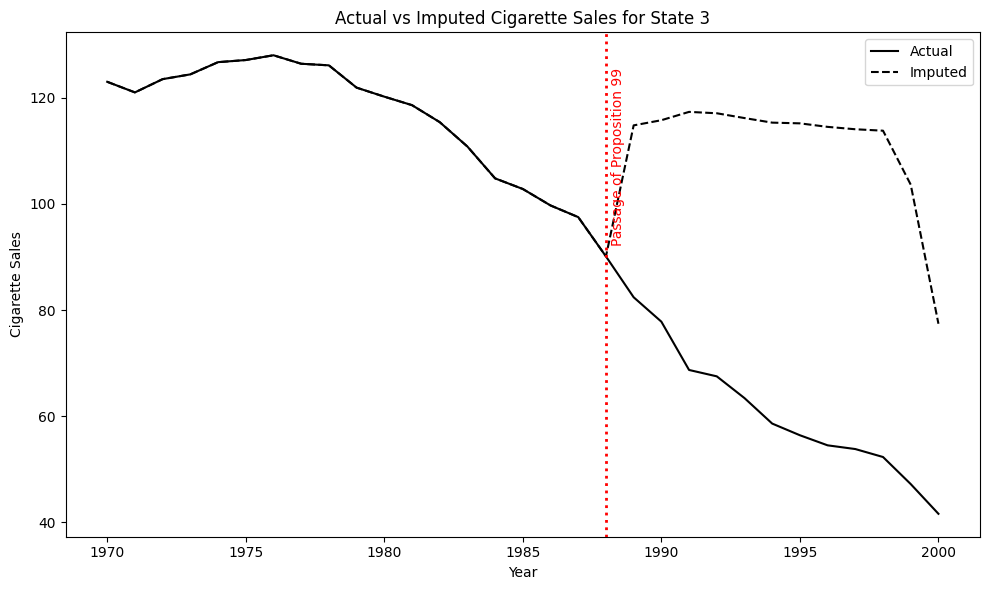

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(comparison_df['year'], comparison_df['actual_cigsale'], color='black', label='Actual', linestyle='-')
plt.plot(comparison_df['year'], comparison_df['imputed_cigsale'], color='black', label='Imputed', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Cigarette Sales')
plt.title('Actual vs Imputed Cigarette Sales for State 3')
plt.legend()
plt.axvline(x=1988, color='red', linestyle=':', linewidth=2)
plt.text(1988 + 0.2, plt.ylim()[1]*0.95, "Passage of Proposition 99", color='red', rotation=90, va='top')
plt.tight_layout()
plt.show()

In [18]:
# Placebo test: repeat synthetic control for states 9, 4, 36, 6, 39 as "treated"
placebo_results = {}

for placebo_state in [36, 6, 39]:
    # 1. Exclude state 3 from the donor pool
    placebo_states = [s for s in states_by_rank if s != 3 and s != placebo_state]
    # 2. Build cigsale matrix for placebo donor pool
    placebo_matrix = subset[subset['state'].isin(placebo_states + [placebo_state])].pivot_table(
        index='state', columns='year', values='cigsale'
    )
    placebo_matrix = placebo_matrix.reindex(index=[placebo_state] + placebo_states, columns=years_sorted)
    # 3. Mask post-1989 for placebo_state
    placebo_matrix.loc[placebo_state, 1989:] = np.nan
    # 4. Prepare data for model
    placebo_np = placebo_matrix.values.astype(np.float32)
    placebo_mask = ~np.isnan(placebo_np)
    placebo_mean = np.nanmean(placebo_np)
    placebo_np_filled = np.where(placebo_mask, placebo_np, placebo_mean)
    # 5. Randomly mask 20% for training
    placebo_rng = np.random.rand(*placebo_mask.shape)
    placebo_train_mask = (placebo_rng > 0.2) & placebo_mask
    placebo_input_tensor = placebo_np_filled[None, ..., None]
    placebo_target_tensor = placebo_np_filled[None, ..., None]
    placebo_train_mask_tensor = placebo_train_mask[None, ..., None]
    # 6. Build and train model
    placebo_model = keras.Sequential([
        layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=input_tensor.shape[1:]),
        layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=input_tensor.shape[1:]),
        layers.Conv2D(1, 3, padding='same')
    ])
    class PlaceboMaskedLoss(keras.losses.Loss):
        def call(self, y_true, y_pred):
            mask = tf.cast(placebo_train_mask_tensor, tf.float32)
            return tf.reduce_sum(mask * tf.square(y_true - y_pred)) / tf.reduce_sum(mask)
    placebo_model.compile(optimizer='adam', loss=PlaceboMaskedLoss())
    placebo_model.fit(placebo_input_tensor, placebo_target_tensor, epochs=500, verbose=0)
    # 7. Predict
    placebo_pred = placebo_model.predict(placebo_input_tensor)[0, ..., 0]
    # 8. Fill in masked values for placebo_state, years >= 1989
    placebo_idx = 0  # first row is placebo_state
    placebo_year_indices = [i for i, y in enumerate(years_sorted) if y >= 1989]
    placebo_matrix_filled = placebo_matrix.copy()
    for yidx in placebo_year_indices:
        placebo_matrix_filled.iloc[placebo_idx, yidx] = placebo_pred[placebo_idx, yidx]
    # 9. Collect actual and imputed for placebo_state
    actual = subset[(subset['state'] == placebo_state) & (subset['year'].isin(years_sorted))].sort_values('year')['cigsale'].values

    imputed = placebo_matrix_filled.loc[placebo_state, years_sorted].values
    placebo_results[placebo_state] = pd.DataFrame({
        'year': years_sorted,
        'actual_cigsale': actual,
        'imputed_cigsale': imputed
    })


/Users/wooyongpark/Dropbox/01 Coursework/02 Stat/08 Deep Learning/final-project/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/Users/wooyongpark/Dropbox/01 Coursework/02 Stat/08 Deep Learning/final-project/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/Users/wooyongpark/Dropbox/01 Coursework/02 Stat/08 Deep Learning/final-project/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [19]:
actual = subset[(subset['state'] == placebo_state) & (subset['year'].isin(years_sorted))].sort_values('year')['cigsale'].values
actual

array([132.19999695, 131.69999695, 140.        , 141.19999695,
       145.80000305, 160.69999695, 161.5       , 160.3999939 ,
       160.30000305, 168.6000061 , 158.1000061 , 163.1000061 ,
       157.69999695, 141.19999695, 128.8999939 , 125.69999695,
       124.80000305, 110.40000153, 114.30000305, 111.40000153,
        96.90000153, 109.09999847, 110.80000305, 108.40000153,
       111.19999695, 115.        , 110.30000305, 108.80000305,
       102.90000153, 104.80000305,  90.5       ])

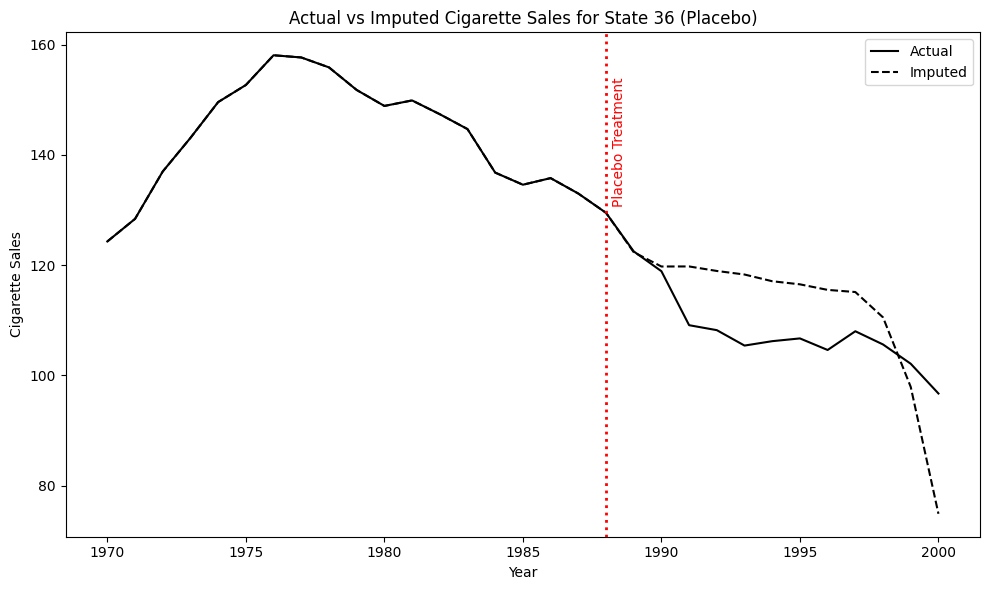

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(placebo_results[36]['year'], placebo_results[36]['actual_cigsale'], label='Actual', color='black', linestyle='-')
plt.plot(placebo_results[36]['year'], placebo_results[36]['imputed_cigsale'], label='Imputed', color='black', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Cigarette Sales')
plt.title('Actual vs Imputed Cigarette Sales for State 36 (Placebo)')
plt.legend()
plt.axvline(x=1988, color='red', linestyle=':', linewidth=2)
plt.text(1988 + 0.2, plt.ylim()[1]*0.95, "Placebo Treatment", color='red', rotation=90, va='top')
plt.tight_layout()
plt.show()

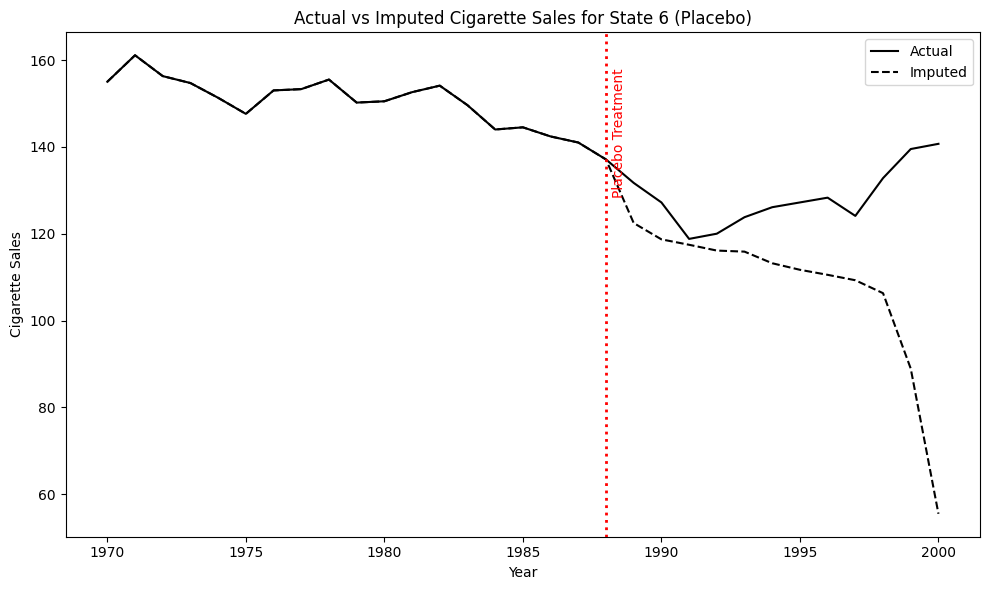

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(placebo_results[6]['year'], placebo_results[6]['actual_cigsale'], label='Actual', color='black', linestyle='-')
plt.plot(placebo_results[6]['year'], placebo_results[6]['imputed_cigsale'], label='Imputed', color='black', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Cigarette Sales')
plt.title('Actual vs Imputed Cigarette Sales for State 6 (Placebo)')
plt.legend()
plt.axvline(x=1988, color='red', linestyle=':', linewidth=2)
plt.text(1988 + 0.2, plt.ylim()[1]*0.95, "Placebo Treatment", color='red', rotation=90, va='top')
plt.tight_layout()
plt.show()

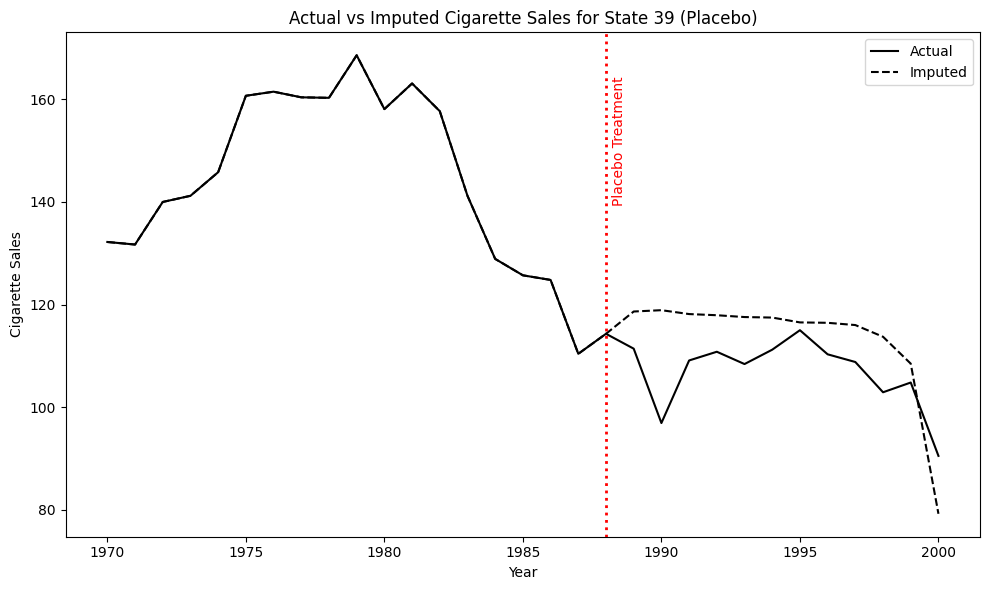

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(placebo_results[39]['year'], placebo_results[39]['actual_cigsale'], label='Actual', color='black', linestyle='-')
plt.plot(placebo_results[39]['year'], placebo_results[39]['imputed_cigsale'], label='Imputed', color='black', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Cigarette Sales')
plt.title('Actual vs Imputed Cigarette Sales for State 39 (Placebo)')
plt.legend()
plt.axvline(x=1988, color='red', linestyle=':', linewidth=2)
plt.text(1988 + 0.2, plt.ylim()[1]*0.95, "Placebo Treatment", color='red', rotation=90, va='top')
plt.tight_layout()
plt.show()